In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
DATA_DIRECTORY = 'datasets/titanic'
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'

In [3]:
titanic = pd.read_csv(os.path.join(DATA_DIRECTORY, TRAIN_FILE))
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_df = titanic.copy()
titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [5]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.8+ KB


In [6]:
titanic_df['Sex'] = titanic_df['Sex'].map({'female':1, 'male':0})

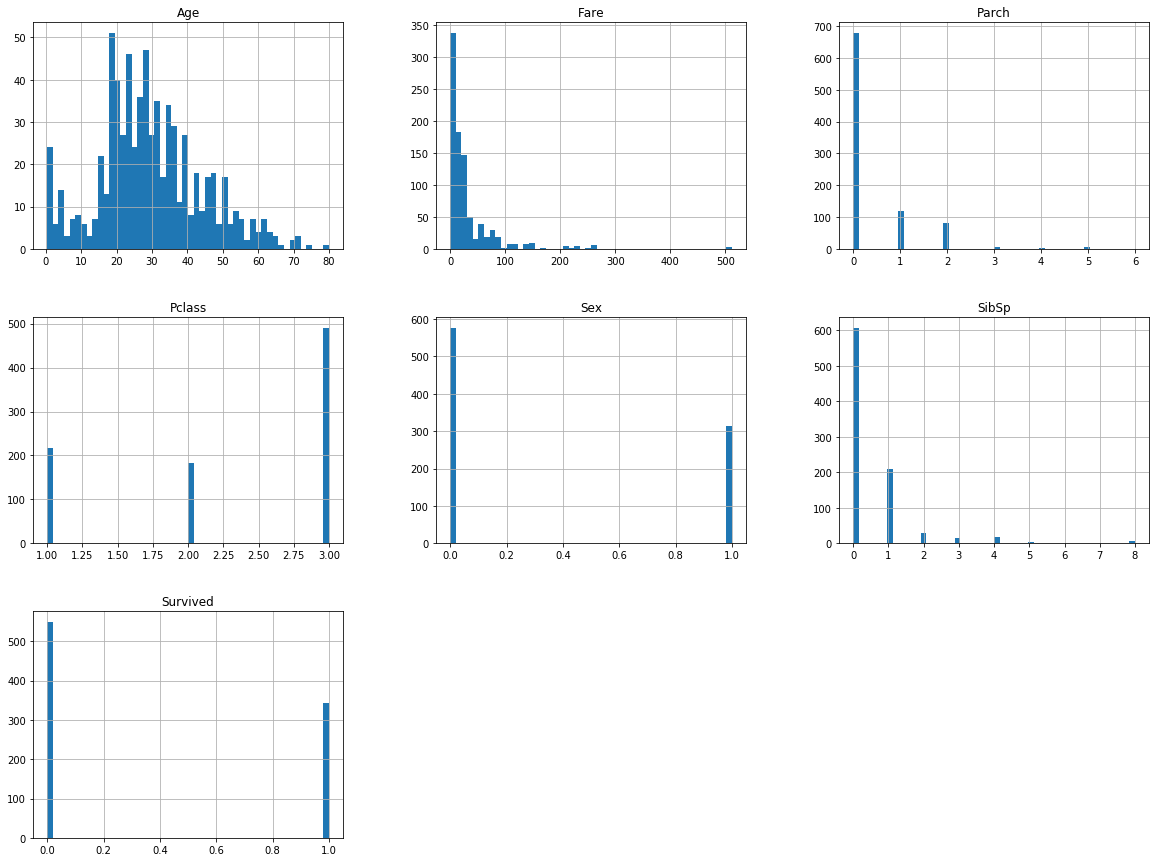

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
titanic_df.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
corr_matrix = titanic_df.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived    1.000000
Sex         0.543351
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

/home/anton/Dev/learn-machine-learning/env/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5aadfb9eb8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5aae1a45c0>]], dtype=object)

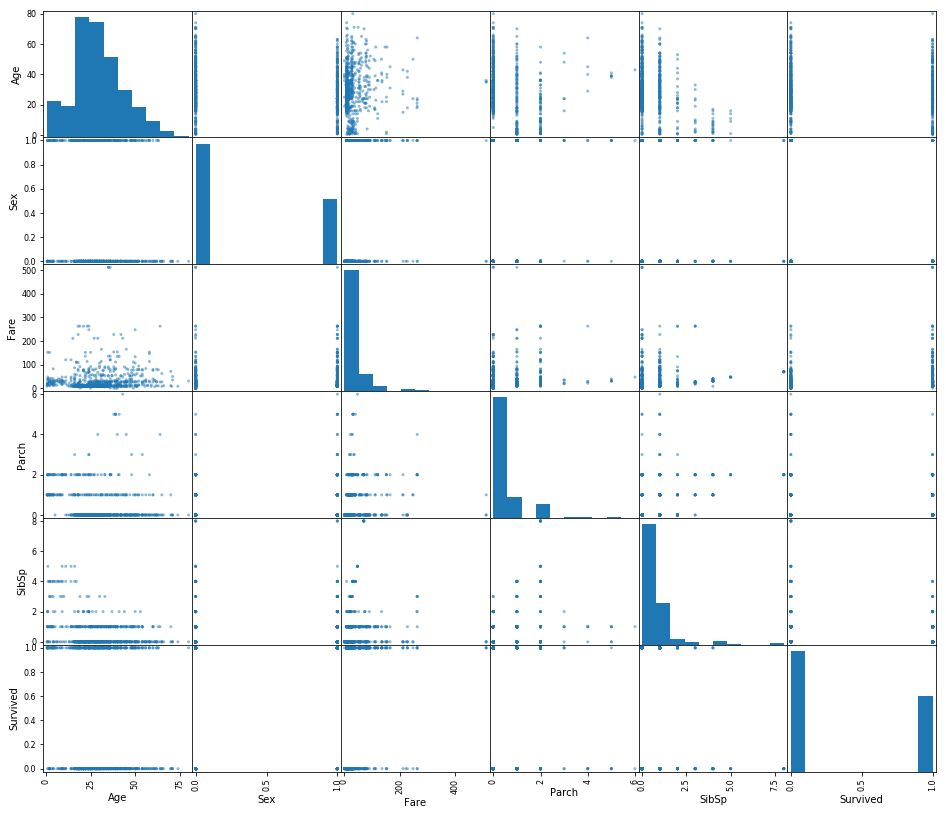

In [9]:
from pandas.tools.plotting import scatter_matrix

attributes = ['Age', 'Sex', 'Fare', 'Parch', 'SibSp', 'Survived']
scatter_matrix(titanic_df[attributes], figsize=(16, 14))

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attribute_names].values

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [12]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('encdoer', CategoricalEncoder(encoding='onehot-dense'))
])

In [14]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

titanic_prepared = full_pipeline.fit_transform(titanic)
titanic_prepared[1]

array([ 0.66386103,  0.43279337, -0.47367361,  0.78684529,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ])

In [15]:
from sklearn.svm import SVC

labels = titanic['Survived'].values

classifier = SVC()
classifier.fit(titanic_prepared, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())
    
scores = cross_val_score(classifier, titanic_prepared, labels, scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [ 0.43461349  0.39440532  0.46204236  0.35156152  0.41053541  0.44971901
  0.41053541  0.44971901  0.36719404  0.38435306]
Mean: 0.41146786494
Standard Deviation: 0.0354920053746


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'C':[1, 0.9, 0.8, 0.7], 'kernel':['linear', 'rbf', 'poly'], 'degree':[1, 2, 3, 4]}
]

grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy')
grid_search.fit(titanic_prepared, labels)

grid_search.best_params_

{'C': 1, 'degree': 1, 'kernel': 'rbf'}

In [22]:
cross_val_score(grid_search.best_estimator_, titanic_prepared, labels, cv=5, scoring='accuracy')

array([ 0.83240223,  0.83240223,  0.81460674,  0.81460674,  0.84745763])